# 3. Fashion MNIST without ResNet

# Label Glossary
I know, I know, having this here is probably bad form!

| Label	| Description |
|:-----:|-------------|
|0	    | T-shirt/top |
|1	    | Trouser     |
|2	    | Pullover    | 
|3	    | Dress       |
|4	    | Coat        |
|5	    | Sandal      |
|6	    | Shirt       |
|7	    | Sneaker     |
|8	    | Bag         |
|9	    | Ankle boot  |

In [2]:
#import boilerplate
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastai.vision.all import *

In [8]:
#there is no verification that the files aren't already downloaded
import wget

train_images_url = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz"
train_labels_url = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz"
test_images_url = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz"
test_labels_url = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz"

wget.download(train_images_url, 'fashion/')
wget.download(train_labels_url, 'fashion/')
wget.download(test_images_url, 'fashion/')
wget.download(test_labels_url, 'fashion/')

'fashion//t10k-labels-idx1-ubyte (1).gz'

In [9]:
#github.com/zalandoresearch/ inspired this, home of mnist fashion

#unpack images and labels

import gzip

with gzip.open('fashion/train-labels-idx1-ubyte.gz', 'rb') as lbpath:
    train_labels_np = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8)

with gzip.open('fashion/train-images-idx3-ubyte.gz', 'rb') as imgpath:
    train_images_np = np.frombuffer(imgpath.read(), dtype=np.uint8, offset=16).reshape(len(train_labels_np), 784)

with gzip.open('fashion/t10k-labels-idx1-ubyte.gz', 'rb') as lbpath:
    test_labels_np = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8)

with gzip.open('fashion/t10k-images-idx3-ubyte.gz', 'rb') as imgpath:
    test_images_np = np.frombuffer(imgpath.read(), dtype=np.uint8, offset=16).reshape(len(test_labels_np), 784)

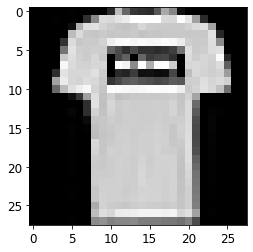

In [24]:
#take a look
plt.imshow((train_images_np[1].reshape(28,28)/255), cmap='gray')

In [25]:
#numpy array to pytorch tensor
train_labels = (torch.tensor(train_labels_np).cuda()).long().view(-1,1)
train_images = (torch.tensor(train_images_np).cuda()).float()/255

test_labels = (torch.tensor(test_labels_np).cuda()).long().view(-1,1)
test_images = (torch.tensor(test_images_np).cuda()).float()/255

train_images.shape,train_labels.shape

(torch.Size([60000, 784]), torch.Size([60000, 1]))

In [26]:
#zip into a training "dataset"
train_data = list(zip(train_images, train_labels))

#zip into a testing "dataset"
test_data = list(zip(test_images, test_labels))

In [27]:
train_dl = DataLoader(train_data, batch_size=256)
test_dl = DataLoader(test_data, batch_size=256)

In [28]:
#define loss function - use the CrossEntropyLoss function to calculate the loss from the predictions and actual values
def mnist_loss(pred, actual):
    loss = nn.CrossEntropyLoss()
    return loss(pred, actual.squeeze())

In [29]:
#calculate the gradient, by first calculating the predictions from the model, calculating the loss
def calc_grad(xb,yb,model):
    #get predictions from model
    pred = model(xb)
    #calculat loss from predictions and actual values
    loss = mnist_loss(pred, yb)
    #calculate the gradient
    loss.backward()
    return loss

In [30]:
#calculate batch accuracy
def batch_accuracy(pred, actual):
    #this took a sec to work out, get the maximum predicted category value, the index of that is the predicted digit
    digit_pred = pred.max(dim=1)[1]
    return (digit_pred == actual.squeeze()).float().mean()

In [212]:
# driver for one training epoch
def train_epoch(model, optimizer):
    batch_loss = []
    #iterate through image/label pairs in data set
    for xb, yb in train_dl:
        #get the prediction from the model, calc the loss, get the gradient
        batch_loss.append(calc_grad(xb, yb, model))
        #update the weights
        optimizer.step()
        #zero the gradients
        optimizer.zero_grad()
    return tensor(batch_loss).mean() 

In [213]:
class BasicOptim:
    #link class to model parameters and learning rate
    def __init__(self, params, lr): 
        self.params, self.lr = list(params), lr
    
    #update weights based on gradient and learning rate
    def step(self):
        for p in self.params:
            p.data -= p.grad.data * self.lr

    #reset gradient        
    def zero_grad(self):
        for p in self.params:
            p.grad = None

In [214]:
#basic network with 4 linear layers interspersed with 3 non-linearities
#accept a 28 * 28 size image and output 10 categories
simple_net = nn.Sequential(
    nn.Linear(28 * 28, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 30),
    nn.ReLU(),
    nn.Linear(30, 10)
).cuda()

In [227]:
#starting accuracy = 0.1001
batch_accuracy(simple_net(test_images), test_labels)

tensor(0.1001, device='cuda:0')

In [216]:
opt = BasicOptim(simple_net.parameters(), lr=0.1)

In [248]:
def train_model(model, epochs, opt):
    for i in range(epochs):
        avg_batch_loss = train_epoch(model, opt)
        print(i, avg_batch_loss.item(), batch_accuracy(simple_net(test_images), test_labels).item())

In [250]:
%%time
train_model(simple_net, 100, opt)

0 0.19152680039405823 0.8757999539375305
1 0.09366913139820099 0.8763999938964844
2 0.09831293672323227 0.8777999877929688
3 0.09028060734272003 0.8766999840736389
4 0.0935819074511528 0.8733999729156494
5 0.09933214634656906 0.8792999982833862
6 0.08945803344249725 0.8761999607086182
7 0.09338471293449402 0.8751999735832214
8 0.09477871656417847 0.877299964427948
9 0.08553333580493927 0.8762999773025513
10 0.17172855138778687 0.8544999957084656
11 0.16082440316677094 0.8725999593734741
12 0.12165138125419617 0.8718000054359436
13 0.09534597396850586 0.8704999685287476
14 0.09269236028194427 0.8768999576568604
15 0.08616535365581512 0.8768999576568604
16 0.08210363239049911 0.8740999698638916
17 0.13882631063461304 0.8704999685287476
18 0.10568881779909134 0.8745999932289124
19 0.09222996234893799 0.8739999532699585
20 0.09720402210950851 0.8737999796867371
21 0.08932159096002579 0.8787999749183655
22 0.08476181328296661 0.8682999610900879
23 0.0922233983874321 0.8628000020980835
24 0.

In [31]:
#final accuracy = 0.8609
batch_accuracy(simple_net(test_images), test_labels)

NameError: name 'simple_net' is not defined

## Now with ResNet18

In [3]:
fashion_path = untar_data('https://sou.box.com/shared/static/twlmuvbz5hjv5530aljkv76gi009s4es.tar')

In [8]:
(fashion_path/'train').ls()

(#10) [Path('C:/Users/heybl/.fastai/data/twlmuvbz5hjv5530aljkv76gi009s4es/train/0'),Path('C:/Users/heybl/.fastai/data/twlmuvbz5hjv5530aljkv76gi009s4es/train/1'),Path('C:/Users/heybl/.fastai/data/twlmuvbz5hjv5530aljkv76gi009s4es/train/2'),Path('C:/Users/heybl/.fastai/data/twlmuvbz5hjv5530aljkv76gi009s4es/train/3'),Path('C:/Users/heybl/.fastai/data/twlmuvbz5hjv5530aljkv76gi009s4es/train/4'),Path('C:/Users/heybl/.fastai/data/twlmuvbz5hjv5530aljkv76gi009s4es/train/5'),Path('C:/Users/heybl/.fastai/data/twlmuvbz5hjv5530aljkv76gi009s4es/train/6'),Path('C:/Users/heybl/.fastai/data/twlmuvbz5hjv5530aljkv76gi009s4es/train/7'),Path('C:/Users/heybl/.fastai/data/twlmuvbz5hjv5530aljkv76gi009s4es/train/8'),Path('C:/Users/heybl/.fastai/data/twlmuvbz5hjv5530aljkv76gi009s4es/train/9')]

In [26]:
test_img = (fashion_path/'train'/'0').ls()[0]
parent_label(test_img)

'0'

# Label Glossary
I know, I know, having this here is probably bad form!

| Label	| Description |
|:-----:|-------------|
|0	    | T-shirt/top |
|1	    | Trouser     |
|2	    | Pullover    | 
|3	    | Dress       |
|4	    | Coat        |
|5	    | Sandal      |
|6	    | Shirt       |
|7	    | Sneaker     |
|8	    | Bag         |
|9	    | Ankle boot  |

In [27]:
def relabel(x):
    labels = {'0': 'T-shirt', '1' : 'Trouser', '2' : 'Pullover', '3' : 'Dress', '4' : 'Coat', '5' : 'Sandal', '6' : 'Shirt', '7' : 'Sneaker', '8' : 'Bag', '9' : 'Ankle Boot'}
    label = parent_label(x)
    return labels[label]

relabel(test_img)


'T-shirt'

In [28]:

fashion = DataBlock(blocks=(ImageBlock, CategoryBlock), 
    get_items = get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=69),
    get_y=relabel,
    item_tfms=[Resize(128)])


In [29]:
dls = fashion.dataloaders(fashion_path/'train')

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


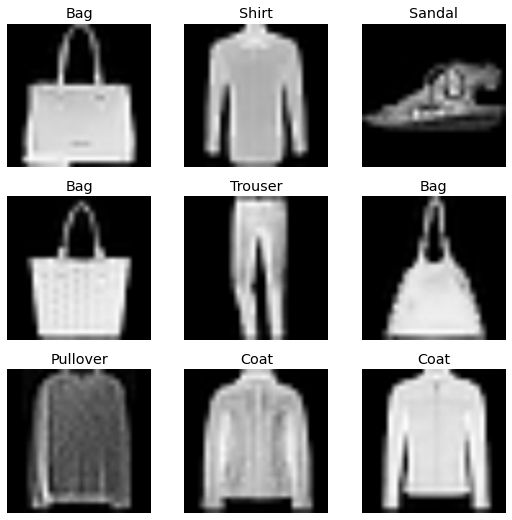

In [30]:
dls.show_batch()

In [42]:
learner = cnn_learner(dls, arch=resnet18, metrics=error_rate)

In [43]:
learner.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.515273,0.424884,0.152000,02:56


epoch,train_loss,valid_loss,error_rate,time
0,0.273852,0.246978,0.088833,02:58
1,0.198984,0.195592,0.067417,02:52
2,0.114190,0.176694,0.058167,02:55
3,0.037009,0.186900,0.056500,03:06


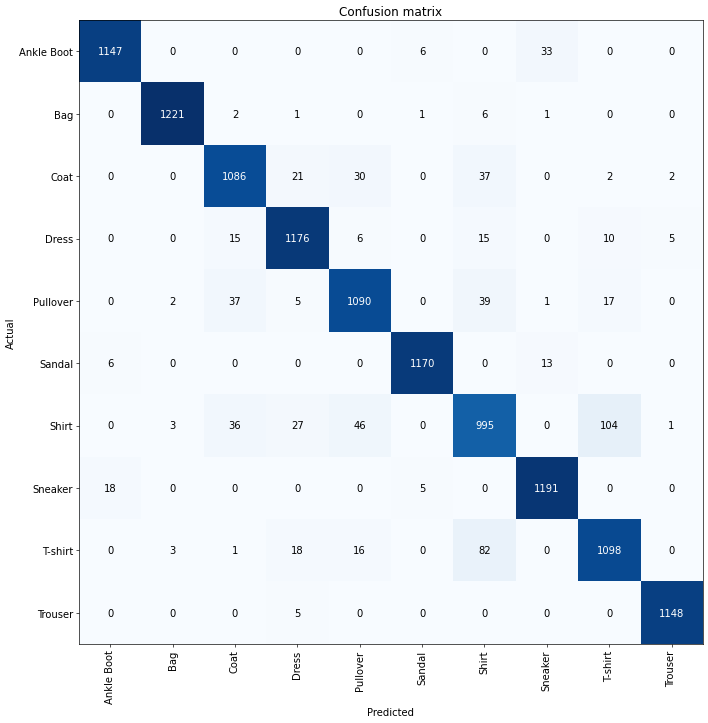

In [44]:
interp = ClassificationInterpretation.from_learner(learner) 
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

# Results

5 total epochs on ResNet18 had an error rate of 5.5%.
Over 100 epochs on my simple network had an error rate of 13.9%.

Obviously ResNet18 surpassed my humble network.